# Classification

The goal of classification is to find a function that separates the data into positive/negative labels. In the case of a linear classifier, this reduces to finding a set of parameters $w^\star$ such that, $$ \begin{align} w^\star &= \arg \min_w \sum_{i=1}^{N} \left[y_i\neq \text{sign} (w^\top x_i) \right] \\ &= \arg \min_w \sum_{i=1}^{N} l_{0/1} (w; x_i, y_i) \end{align}.$$ 

The problem with the $l_{0/1}$ loss, is that it is non-convex (and non-differentiable), hence other surrogate losses must be used to optimize the number of points. 

In [1]:
# Code source: Sebastian Curi and Andreas Krause, based on Jaques Grobler (sklearn demos).
# License: BSD 3 clause

# We start importing some modules and running some magic commands
% matplotlib inline
% reload_ext autoreload
% load_ext autoreload
% autoreload 2

# General math and plotting modules.
import numpy as np
import matplotlib.pyplot as plt

# Project files.
from util import gradient_descent, generate_linear_separable_data, generate_circular_separable_data
import plot_helpers
from classifiers import Perceptron, SVM, Logistic
from regularizers import L1Regularizer, L2Regularizer

# Widget and formatting modules
import ipywidgets
from ipywidgets import interact, interactive, interact_manual
import pylab
# If in your browser the figures are not nicely vizualized, change the following line. 
pylab.rcParams['figure.figsize'] = (10, 5)

# Machine Learning library. 
import sklearn
from sklearn import svm
from sklearn.linear_model import SGDClassifier

import warnings
warnings.filterwarnings('ignore')
# from sklearn import datasets, linear_model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


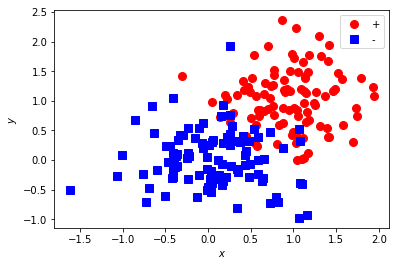

In [2]:
num_points = 100  # Number of points per class
noise = 0.5  # Noise Level (needed for data generation).
np.random.seed(42)
X, Y = generate_linear_separable_data(num_points, noise=noise, dim=2)
# X = X - np.mean(X)

fig = plt.subplot(111)
opt = {'marker': 'ro', 'label': '+', 'size': 8}
plot_helpers.plot_data(X[np.where(Y == 1)[0], 0], X[np.where(Y == 1)[0], 1], fig=fig, options=opt)
opt = {'marker': 'bs', 'label': '-', 'x_label': '$x$', 'y_label': '$y$', 'size': 8, 'legend': True}
plot_helpers.plot_data(X[np.where(Y == -1)[0], 0], X[np.where(Y == -1)[0], 1], fig=fig, options=opt)

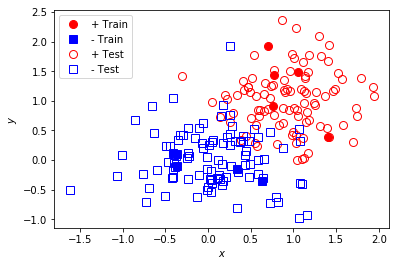

In [3]:
# Separate into train and test sets!
np.random.seed(42)
indexes = np.arange(0, 2*num_points, 1)
np.random.shuffle(indexes)
num_train = int(np.ceil(2*.05*num_points))

X_train = X[indexes[:num_train]]
Y_train = Y[indexes[:num_train]]

X_test = X[indexes[num_train:]]
Y_test = Y[indexes[num_train:]]

fig = plt.subplot(111)

opt = {'marker': 'ro', 'fillstyle': 'full', 'label': '+ Train', 'size': 8}
plot_helpers.plot_data(X_train[np.where(Y_train == 1)[0], 0], X_train[np.where(Y_train == 1)[0], 1], fig=fig, options=opt)
opt = {'marker': 'bs', 'fillstyle': 'full', 'label': '- Train', 'size': 8}
plot_helpers.plot_data(X_train[np.where(Y_train == -1)[0], 0], X_train[np.where(Y_train == -1)[0], 1], fig=fig, options=opt)

opt = {'marker': 'ro', 'fillstyle': 'none', 'label': '+ Test', 'size': 8}
plot_helpers.plot_data(X_test[np.where(Y_test == 1)[0], 0], X_test[np.where(Y_test == 1)[0], 1], fig=fig, options=opt)
opt = {'marker': 'bs', 'fillstyle': 'none', 'label': '- Test', 'size': 8, 
       'x_label': '$x$', 'y_label': '$y$', 'legend': True}
plot_helpers.plot_data(X_test[np.where(Y_test == -1)[0], 0], X_test[np.where(Y_test == -1)[0], 1], fig=fig, options=opt)


## The Perceptron Algorithm

The perceptron loss is defined as: $$L(w; X, Y) =  \sum_{i=1}^{N} L_p(w; x_i, y_i) = \sum_{i=1}^{N} \max \{ 0, -y_i w^\top x_i \}.$$

The loss function is continuous, but not differentialbe at $y_i w^\top x_i=0$. The subgradient, however, exists and hence (stochastic) gradient descent converges. The subgradient is:

$$ \partial L_p(w; x_i,y_i) = \left\{\begin{array}{cc} 0 & \text{if } -y_i w^\top x_i < 0 \\ -y_i x_i & \text{if } -y_i w^\top x_i > 0 \\ \left[0, -y_i x_i \right] & \text{if } -y_i w^\top x_i = 0 \end{array}  \right. $$

In [4]:
def change_learning_params(reg, eta0, n_iter, batch_size):
    classifier = Perceptron(X_train, Y_train)
    classifier.load_test_data(X_test, Y_test)
    
    regularizer = L2Regularizer(np.power(10., reg))
    np.random.seed(42)
    w0 = np.random.randn(3, )

    opts = {'eta0': eta0,
            'n_iter': n_iter,
            'batch_size': batch_size,
            'n_samples': X_train.shape[0],
            'algorithm': 'SGD',
            'learning_rate_scheduling': None,
            }
    trajectory, indexes = gradient_descent(w0, classifier, regularizer, opts)

    contour_plot = plt.subplot(121)
    error_plot = plt.subplot(122)
    
    opt = {'marker': 'ro', 'fillstyle': 'full', 'label': '+ Train', 'size': 8}
    plot_helpers.plot_data(X_train[np.where(Y_train == 1)[0], 0], X_train[np.where(Y_train == 1)[0], 1], fig=contour_plot, options=opt)
    opt = {'marker': 'bs', 'fillstyle': 'full', 'label': '- Train', 'size': 8}
    plot_helpers.plot_data(X_train[np.where(Y_train == -1)[0], 0], X_train[np.where(Y_train == -1)[0], 1], fig=contour_plot, options=opt)

    opt = {'marker': 'ro', 'fillstyle': 'none', 'label': '+ Test', 'size': 8}
    plot_helpers.plot_data(X_test[np.where(Y_test == 1)[0], 0], X_test[np.where(Y_test == 1)[0], 1], fig=contour_plot, options=opt)
    opt = {'marker': 'bs', 'fillstyle': 'none', 'label': '- Test', 'size': 8}
    plot_helpers.plot_data(X_test[np.where(Y_test == -1)[0], 0], X_test[np.where(Y_test == -1)[0], 1], fig=contour_plot, options=opt)

    contour_opts = {'n_points': 50, 'x_label': '$x$', 'y_label': '$y$', 'sgd_point': True, 'n_classes': 4}
    error_opts = {'epoch': 5, 'x_label': '$t$', 'y_label': 'error'}
    
    opts = {'contour_opts': contour_opts, 'error_opts': error_opts}
    plot_helpers.classification_progression(X, Y, trajectory, indexes, classifier, 
                                            contour_plot=contour_plot, error_plot=error_plot, 
                                            options=opts)

interact_manual(change_learning_params,
                reg=ipywidgets.FloatSlider(value=-3,
                                    min=-3,
                                    max=3,
                                    step=0.5,
                                    readout_format='.1f',
                                    description='Regularization 10^:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False), 
                eta0=ipywidgets.FloatSlider(value=1,
                                            min=1e-1,
                                            max=2,
                                            step=1 * 1e-1,
                                            readout_format='.1f',
                                            description='Learning rate:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                n_iter=ipywidgets.IntSlider(value=30,
                                            min=5,
                                            max=100,
                                            step=1,
                                            description='Number of iterations:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                batch_size=ipywidgets.IntSlider(value=1,
                                            min=1,
                                            max=X_train.shape[0],
                                            step=1,
                                            description='Batch Size:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False)
               );

interactive(children=(FloatSlider(value=-3.0, continuous_update=False, description='Regularization 10^:', max=3.0, min=-3.0, readout_format='.1f', step=0.5, style=SliderStyle(description_width='initial')), FloatSlider(value=1.0, continuous_update=False, description='Learning rate:', max=2.0, min=0.1, readout_format='.1f', style=SliderStyle(description_width='initial')), IntSlider(value=30, continuous_update=False, description='Number of iterations:', min=5, style=SliderStyle(description_width='initial')), IntSlider(value=1, continuous_update=False, description='Batch Size:', max=10, min=1, style=SliderStyle(description_width='initial')), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

## The SVM Algorithm

The svm loss is defined as: $$L(w; X, Y) =  \sum_{i=1}^{N} L_{\text{svm}} (w; x_i, y_i) =  \sum_{i=1}^{N} \max \{ 0, 1-y_i w^\top x_i \}.$$

The loss function is continuous, but not differentialbe at $y_i w^\top x_i=0$. The subgradient, however, exists and hence (stochastic) gradient descent converges. The subgradient is:

$$ \partial L_{\text{svm}}(w;x_i,y_i) = \left\{\begin{array}{cc} 0 & \text{if } 1-y_i w^\top x_i < 0 \\ -y_i x_i & \text{if } 1-y_i w^\top x_i > 0 \\ \left[0, -y_i x_i \right] & \text{if } 1-y_i w^\top x_i = 0 \end{array}  \right. $$

The difference with the perceptron loss is that the SVM loss includes a loss margin. 

In [5]:
def change_learning_params(reg, eta0, n_iter, batch_size):
    classifier = SVM(X_train, Y_train)
    classifier.load_test_data(X_test, Y_test)
    
    regularizer = L2Regularizer(np.power(10., reg))
    np.random.seed(42)
    w0 = np.random.randn(3, )

    opts = {'eta0': eta0,
            'n_iter': n_iter,
            'batch_size': batch_size,
            'n_samples': X_train.shape[0],
            'algorithm': 'SGD',
            'learning_rate_scheduling': None
            }

    trajectory, indexes = gradient_descent(w0, classifier, regularizer, opts)
    
    contour_plot = plt.subplot(121)
    error_plot = plt.subplot(122)
    
    opt = {'marker': 'ro', 'fillstyle': 'full', 'label': '+ Train', 'size': 8}
    plot_helpers.plot_data(X_train[np.where(Y_train == 1)[0], 0], X_train[np.where(Y_train == 1)[0], 1], fig=contour_plot, options=opt)
    opt = {'marker': 'bs', 'fillstyle': 'full', 'label': '- Train', 'size': 8}
    plot_helpers.plot_data(X_train[np.where(Y_train == -1)[0], 0], X_train[np.where(Y_train == -1)[0], 1], fig=contour_plot, options=opt)

    opt = {'marker': 'ro', 'fillstyle': 'none', 'label': '+ Test', 'size': 8}
    plot_helpers.plot_data(X_test[np.where(Y_test == 1)[0], 0], X_test[np.where(Y_test == 1)[0], 1], fig=contour_plot, options=opt)
    opt = {'marker': 'bs', 'fillstyle': 'none', 'label': '- Test', 'size': 8}
    plot_helpers.plot_data(X_test[np.where(Y_test == -1)[0], 0], X_test[np.where(Y_test == -1)[0], 1], fig=contour_plot, options=opt)

    contour_opts = {'n_points': 100, 'x_label': '$x$', 'y_label': '$y$', 'sgd_point': True, 'n_classes': 4}
    error_opts = {'epoch': 5, 'x_label': '$t$', 'y_label': 'error'}
    
    opts = {'contour_opts': contour_opts, 'error_opts': error_opts}
    plot_helpers.classification_progression(X, Y, trajectory, indexes, classifier, 
                                            contour_plot=contour_plot, error_plot=error_plot, 
                                            options=opts)

interact_manual(change_learning_params,
                reg=ipywidgets.FloatSlider(value=-3,
                                    min=-3,
                                    max=3,
                                    step=0.5,
                                    readout_format='.1f',
                                    description='Regularization 10^:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False), 
                eta0=ipywidgets.FloatSlider(value=1,
                                            min=1e-1,
                                            max=2,
                                            step=1 * 1e-1,
                                            readout_format='.1f',
                                            description='Learning rate:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                n_iter=ipywidgets.IntSlider(value=50,
                                            min=5,
                                            max=100,
                                            step=1,
                                            description='Number of iterations:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                batch_size=ipywidgets.IntSlider(value=1,
                                            min=1,
                                            max=X_train.shape[0],
                                            step=1,
                                            description='Batch Size:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False)
               );

interactive(children=(FloatSlider(value=-3.0, continuous_update=False, description='Regularization 10^:', max=3.0, min=-3.0, readout_format='.1f', step=0.5, style=SliderStyle(description_width='initial')), FloatSlider(value=1.0, continuous_update=False, description='Learning rate:', max=2.0, min=0.1, readout_format='.1f', style=SliderStyle(description_width='initial')), IntSlider(value=50, continuous_update=False, description='Number of iterations:', min=5, style=SliderStyle(description_width='initial')), IntSlider(value=1, continuous_update=False, description='Batch Size:', max=10, min=1, style=SliderStyle(description_width='initial')), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

# L1 Regularization

The L-1 regularization method uses a regularizer of the form $R(w) = ||w||_1$ which is non-differentiable. However, the subgradient exits and is:

$$\partial(||w|||_1) = \left\{\begin{array}{cc} \text{sign} (w)& \text{if } w \neq 0 \\ [-1, 1]  & \text{if } w = 0 \end{array} \right. $$

This regularization method penalizes weights and induces sparsity in the solutions. That is, most of the entries of the solution $w^\star$ will be zero. 

In [6]:
num_positive = 50  # Number of points per class
num_negative = 50  # Number of points per class

noise = 0.3  # Noise Level (needed for data generation).

X, Y = generate_linear_separable_data(num_positive, num_negative, offset=np.array([1, .2]), noise=noise, dim=2)
X = X - np.mean(X, axis=0)

def regularization(regularizer, reg):
    np.random.seed(42)
    classifier = SGDClassifier(loss='hinge', penalty=regularizer, alpha = np.power(10., reg), random_state=1)
    classifier.fit(X[:,:2], Y)
    
    X0, X1 = X[:, 0], X[:, 1]
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = .02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    fig = plt.subplot(111)
    contour = plot_helpers.plot_contours(fig, classifier, xx, yy, cmap=plt.cm.jet, alpha=0.3)
    plt.colorbar(contour)
    opt = {'marker': 'r*', 'label': '+'}
    plot_helpers.plot_data(X[np.where(Y == 1)[0], 0], X[np.where(Y == 1)[0], 1], fig=fig, options=opt)
    opt = {'marker': 'bs', 'label': '-', 'legend': True}
    plot_helpers.plot_data(X[np.where(Y == -1)[0], 0], X[np.where(Y == -1)[0], 1], fig=fig, options=opt)
    
interact(regularization,
         regularizer=ipywidgets.RadioButtons(
             options=['l1', 'l2'],
             value='l1',
             description='Algorithm:',
             style={'description_width': 'initial'}),
         reg=ipywidgets.FloatSlider(
             value=-3,
             min=-3,
             max=0,
             step=0.5,
             description='Regularizer 10^:',
             style={'description_width': 'initial'},
             continuous_update=False)
         );

interactive(children=(RadioButtons(description='Algorithm:', options=('l1', 'l2'), style=DescriptionStyle(description_width='initial'), value='l1'), FloatSlider(value=-3.0, continuous_update=False, description='Regularizer 10^:', max=0.0, min=-3.0, step=0.5, style=SliderStyle(description_width='initial')), Output()), _dom_classes=('widget-interact',))